In [19]:
from drivecycle import route, simplification, energy
import pandas as pd
from matplotlib import pyplot as plt
import json

# Drivecycle Example

## Load Sample Data

The sample elevation and edge data is for a bus route shape matched to OSM edges using [Valhalla Map Matching](https://valhalla.github.io/valhalla/api/map-matching/api-reference/). The "end" column denotes the tag of the intersecting edge at the end of the segement. Speed is in `m/s`

In [25]:
route_id=10

df = pd.read_json(f"../tests/data/calgary-{route_id}-edges.json")

with open(f'../tests/data/calgary-{route_id}-elv.json', 'r') as f:
    elv = json.load(f)

df

,speed,end,lr
0,0.00,bus_stop,0
1,5.56,service_other,27
2,5.56,service_other,39
3,5.56,service_other,46
4,5.56,service_other,63
...,...,...,...
331,13.89,service_other,14895
332,13.89,tertiary,14904
333,13.89,service_other,14914
334,13.89,service_other,14957


## Path Simplification

The Valhalla map mathing results in many interstitial nodes causing many short segments that have infeasible trajectories. Therefore the path must be simplified by clustering close neighbouring nodes along the route. The clustering reduces the number of rows from 336 to 75

In [76]:
df_simplified = simplification.cluster_nodes(df,buffer=30) #buffer nodes by 30m
df_simplified

,speed,end,lr
0,4.448000,"[bus_stop, service_other, service_other, servi...",31.60
1,6.808000,"[service_other, service_other, service_other, ...",248.59
2,10.351818,"[bus_stop, residential, unclassified, tertiary...",737.08
3,11.110000,"[service_other, tertiary, service_other, bus_s...",952.14
4,11.110000,[service_other],1043.00
...,...,...,...
70,13.890000,"[service_other, bus_stop, service_other, prima...",13922.93
71,13.890000,"[service_other, service_other, secondary, serv...",14235.52
72,13.890000,"[service_other, secondary, service_other, bus_...",14571.03
73,13.890000,[service_other],14830.00


## Creating Trajectory

The trajectory is created using the simplified path and stop parameters that define the stopping durations at the "end" tag if it exists. 

In [33]:
stop_params = {
    "bus_stop":60,
    "tertiary":120,
    "secondary":180,
}

tvq = route.sequential(
    df_simplified,
    stop_params, 
    step=2, #time step
    a_max=2 #acceleration
)

tvq

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.00000000e+00, 4.00000000e+00],
       [2.00000000e+00, 4.44800000e+00, 1.28458240e+01],
       ...,
       [1.61300000e+03, 0.00000000e+00, 1.49321244e+04],
       [1.61400000e+03, 0.00000000e+00, 1.49321244e+04],
       [1.61500000e+03, 0.00000000e+00, 1.49321244e+04]])

## Plotting the Trajectory Results

We can plot a number of charts that show the trajectory.

In [47]:
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 11})

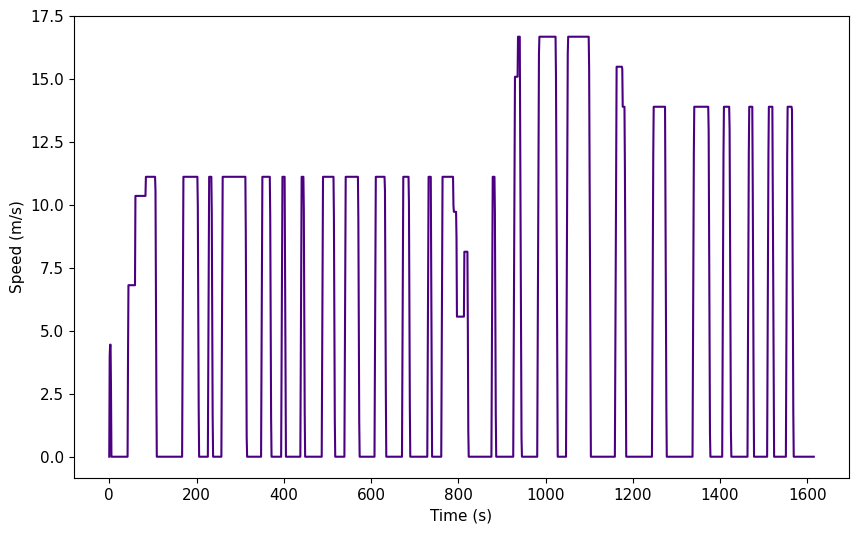

In [48]:
plt.figure(figsize=(10, 6))
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.plot(tvq[:,0], tvq[:,1], color='#4b0082', linewidth=1.5)
plt.show()

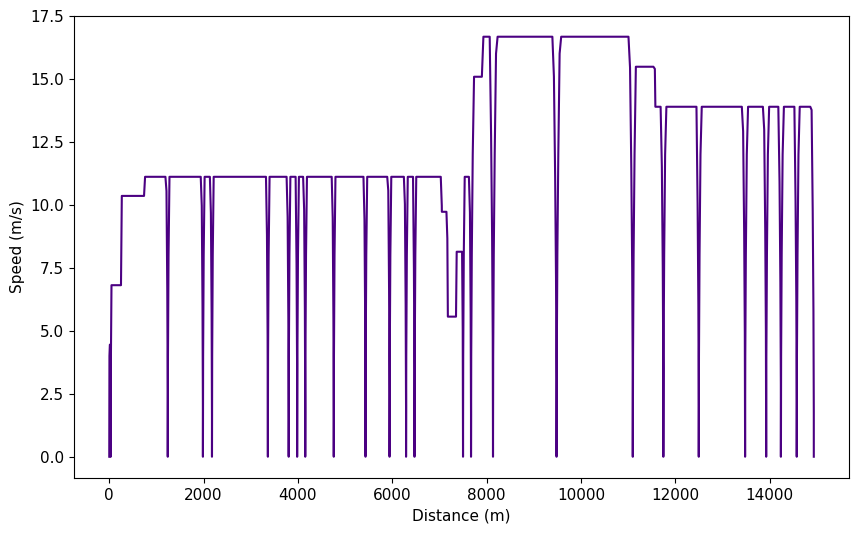

In [50]:
plt.figure(figsize=(10, 6))
plt.xlabel("Distance (m)")
plt.ylabel("Speed (m/s)")
plt.plot(tvq[:,2], tvq[:,1], color='#4b0082', linewidth=1.5)
plt.show()

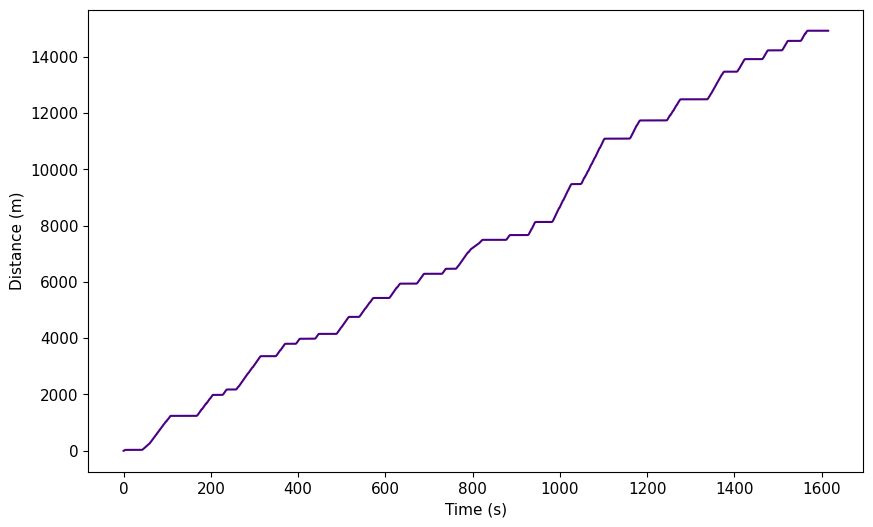

In [52]:
plt.figure(figsize=(10, 6))
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.plot(tvq[:,0], tvq[:,2], color='#4b0082', linewidth=1.5)
plt.show()

## Energy Modelling

We can model the energy consumption of an EV based on certain vehicle parameters.

In [71]:
# The following energy model is for a 40ft electric bus

e = energy.energy_model(
    tvq, 
    elv, 
    capacity=450,#battery capacity in kWh 
    regen_ratio=0.5, 
    m=10000, 
    power_aux=10 #kWh
)

## Plotting Cumulative Power Consumption

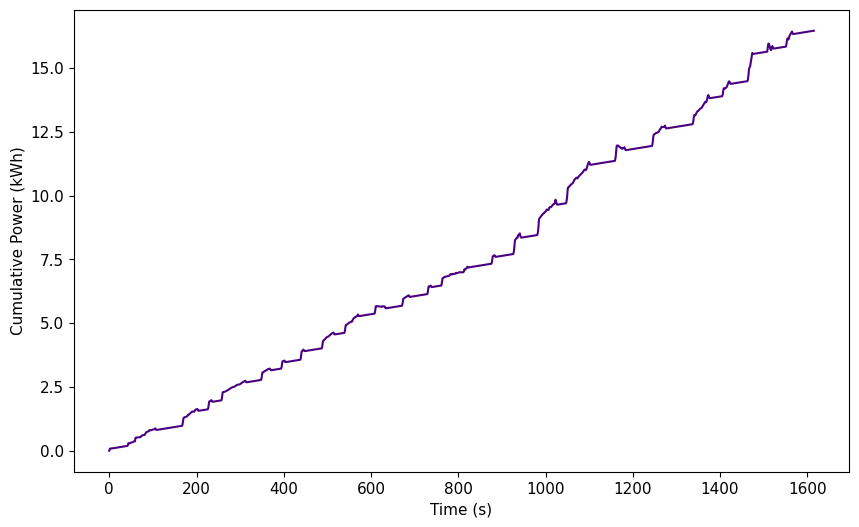

In [72]:
plt.figure(figsize=(10, 6))
plt.xlabel("Time (s)")
plt.ylabel("Cumulative Power (kWh)")
plt.plot(e[:,0], e[:,3], color='#4b0082', linewidth=1.5)
plt.show()

## Plotting State of Charge Change

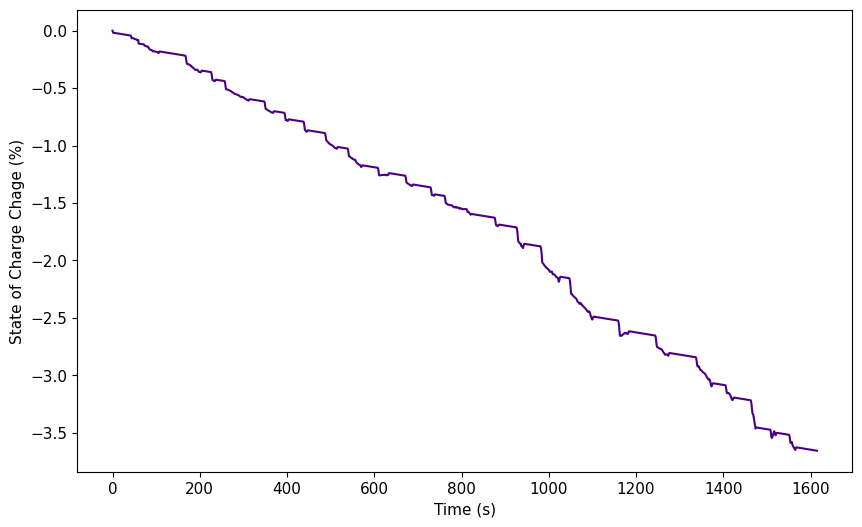

In [73]:
plt.figure(figsize=(10, 6))
plt.xlabel("Time (s)")
plt.ylabel("State of Charge Chage (%)")
plt.plot(e[:,0], e[:,4], color='#4b0082', linewidth=1.5)
plt.show()

In [74]:
pow_efficiency = (e[-1,3]/e[-1,2])*1000
print(f"Power Efficiency (kWh/km): {pow_efficiency}")

Power Efficiency (kWh/km): 1.10222189258785
